# Wine review NLP

We try to predict the point given by critics based on their description of the wine. 

- We use the term frequency - inverse document frequency (tf-idf) to generate features to analyze the data

- We do a weighted stochastic linear regression on the features and the points to fit the data.

    - Batch gradient descent has to be used because the dataset is too high dimensional. 
    - The sample data needs to be weighted because the points are distributed heavily around the mean value.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = (16.0, 9.0)

## Import and preprocess data

In [3]:
df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
print (df.shape)

(129971, 13)


In [4]:
df['desc_len'] = df['description'].apply(len)

In [5]:
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_len
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,172
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,227


### Check the distributions of the length of 'description' and 'points'

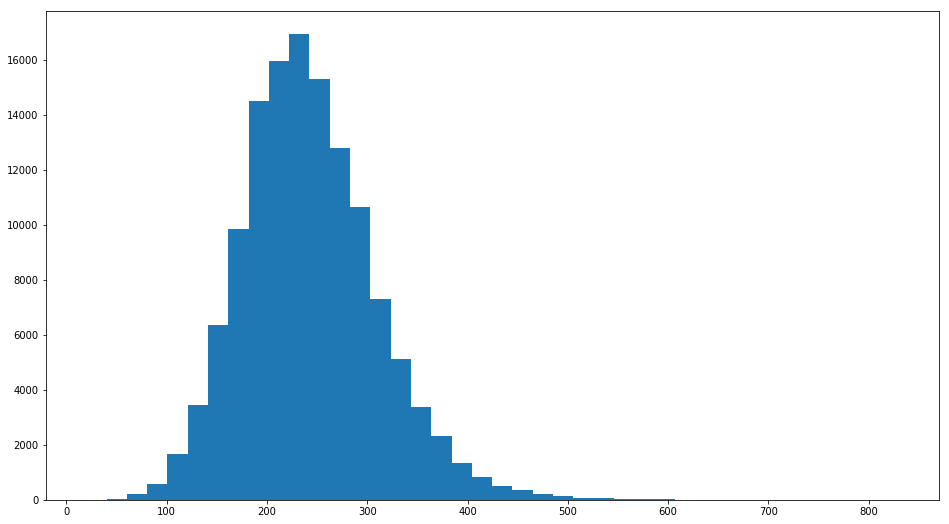

In [6]:
u = plt.hist(df.desc_len, bins=40)

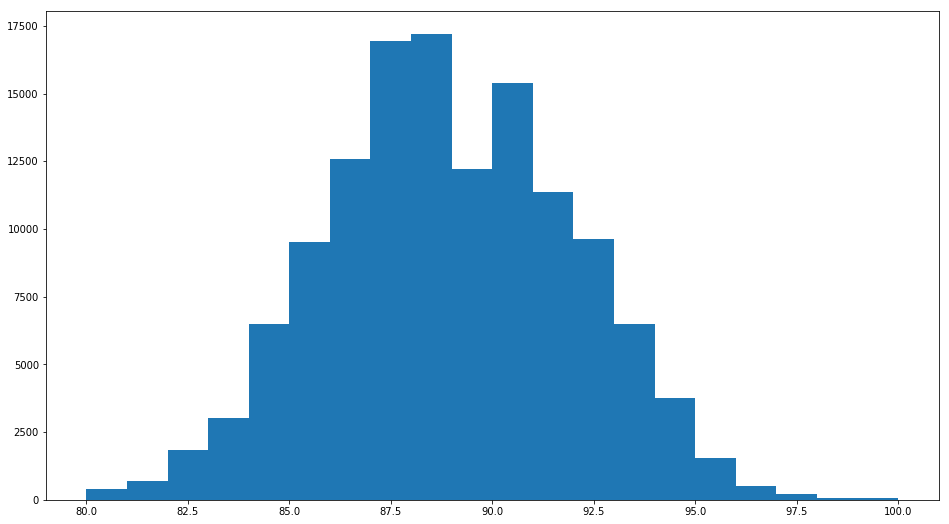

In [7]:
u = plt.hist(df.points, bins=20)

### Remove duplicate entries

In [8]:
m = df.shape[0]
print('Percentage of duplicate entries {:.1f}%'.format(100*(m - df.description.nunique())/m))

Percentage of duplicate entries 7.7%


In [9]:
# Count unique values
cnts = df.description.value_counts()
cnts[cnts > 1]

# Check if the duplicate descriptions refer to the same wine
# (i.e. maybe the same description was used by a lazy taster)
text = cnts.index[0]
df[df.description == text]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_len
13143,US,"Cigar box, café au lait, and dried tobacco aro...",Estate Grown,88,30.0,Washington,Red Mountain,Columbia Valley,Sean P. Sullivan,@wawinereport,Ambassador Vineyard 2013 Estate Grown Syrah (R...,Syrah,Ambassador Vineyard,199
25181,US,"Cigar box, café au lait, and dried tobacco aro...",Estate Grown,88,30.0,Washington,Red Mountain,Columbia Valley,Sean P. Sullivan,@wawinereport,Ambassador Vineyard 2013 Estate Grown Syrah (R...,Syrah,Ambassador Vineyard,199
25182,US,"Cigar box, café au lait, and dried tobacco aro...",Estate,88,30.0,Washington,Red Mountain,Columbia Valley,Sean P. Sullivan,@wawinereport,Ambassador Vineyard 2013 Estate Syrah (Red Mou...,Syrah,Ambassador Vineyard,199


In [10]:
# Drop rows that have the same description
df = df.drop_duplicates(subset='description')
df.shape

(119955, 14)

## TF-IDF feature generation

In [11]:
""" Feature engineering:
Use Term Frequency - Inverse Document Frequency (TF-IDF) to create features
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [12]:
# Generate features (X) and labels (y)
X = df.description
point_mean = df.points.mean()
point_std = df.points.std()
y = (df.points - point_mean) / point_std

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(83968,)
(35987,)


In [13]:
# Generate tf-idf features
n = 3
tfv = TfidfVectorizer(min_df=3,                # minimum document frequency of the word
                      max_features=None,
                      analyzer='word',
                      token_pattern=r'\w{1,}', # alphanumeric character + 1 or more repetition
                      ngram_range=(1,n),       # make vocabulary with 1 to 3 words ngram
                      use_idf=1,               # use inverse document frequency
                      smooth_idf=1, 
                      sublinear_tf=1,
                      stop_words = 'english'
                     )

start = time.time()
X_train_vect = tfv.fit_transform(X_train)
end = time.time()

print('Time to train vectorizer and transform training text: %0.2fs' % (end - start))

Time to train vectorizer and transform training text: 11.92s


## Model fit: without sample weighting

In [14]:
# The SGDRegressor is faster than the conventional LinearRegressor
model = SGDRegressor(loss='squared_loss', max_iter=5)
params = {'penalty':['none','l1','l2'],
          'alpha': np.logspace(-4, -1, 5)}
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=5)

start = time.time()
gs.fit(X_train_vect, y_train)
end = time.time()
print('Time to train model: %0.2fs' % (end -start))

Time to train model: 7.89s


In [15]:
# Check the best parameter and score
model = gs.best_estimator_
print('best alpha: {:.4f}'.format(gs.best_params_['alpha']))
print('best score: {:.3f}'.format(gs.best_score_))

best alpha: 0.1000
best score: -0.849


In [16]:
# Generate predictions using scikit-learn's pipeline
pipe = Pipeline([('vect', tfv), ('model', model)])
start = time.time()
y_pred = pipe.predict(X_test)
end = time.time()

print('Time to generate predictions on test set: %0.2fs' % (end - start))

Time to generate predictions on test set: 1.95s


In [17]:
# Check the mean squared error
error = point_std * mean_squared_error(y_test, y_pred)
print('mean squared error: {:.2f}'.format(error))

mean squared error: 2.52


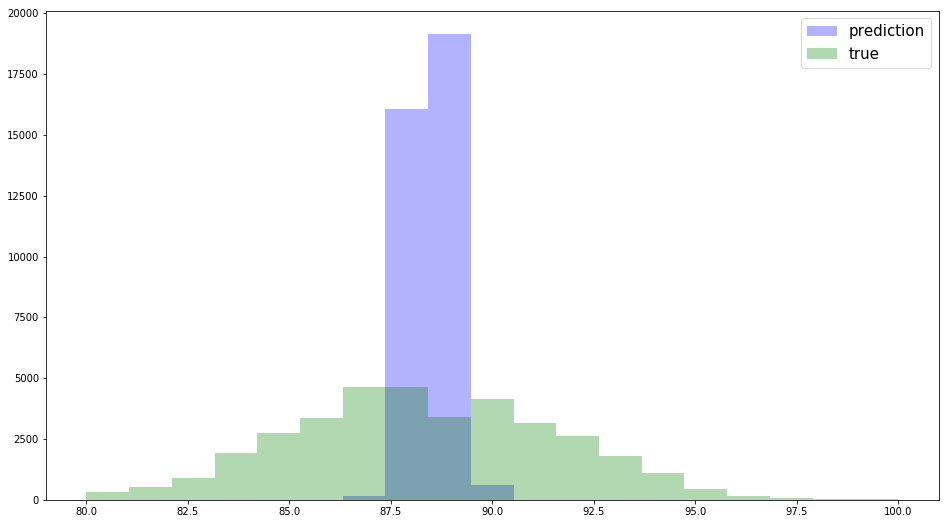

In [18]:
# Plot the distribution of scores 
def to_point(y):
    return y * point_std + point_mean

bins = np.linspace(80, 100, 20)

fig = plt.figure()
ax = plt.gca()
ax.hist(to_point(y_pred), bins=bins, alpha=0.3, color='b', label='prediction')
ax.hist(to_point(y_test), bins=bins, alpha=0.3, color='g', label='true')
ax.legend(prop={'size':15})


- If we don't use sample weights, the model simply predicts average value.

In [19]:
# Build a list of vocabulary outputs of tf-idf vectorizer
import operator
sorted_dict = sorted(tfv.vocabulary_.items(), key=operator.itemgetter(1))
indices_word = list(list(zip(*sorted_dict))[0])

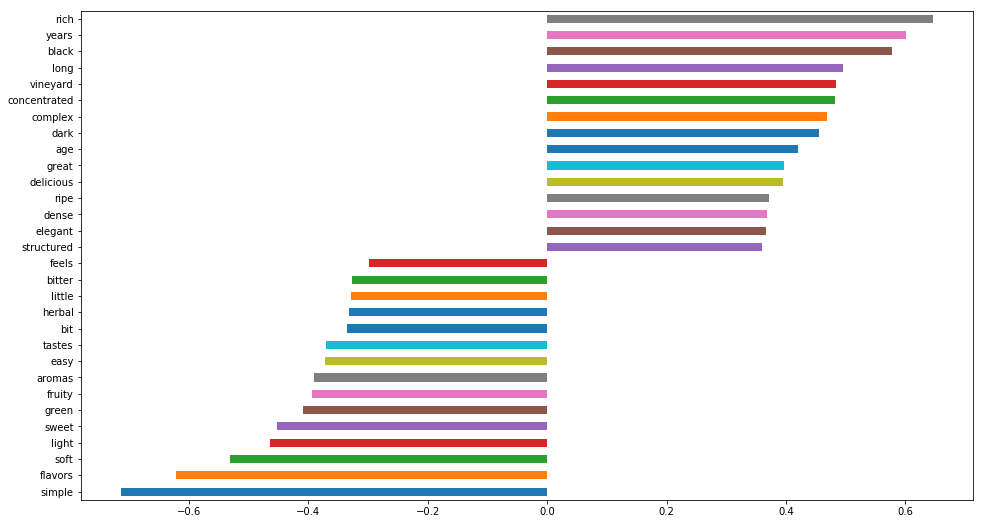

In [20]:
coef = pd.Series(model.coef_, index = indices_word)
num_coef = 15
imp_coef = pd.concat([coef.sort_values().head(num_coef),
                      coef.sort_values().tail(num_coef)])

plt.figure()
imp_coef.plot(kind='barh')

- Some of the "positive" and "negative" words make sense but neutral words like "vineyard" and "aromas" are wrongly attributed as positive and negative words, respectively.

## Model fit: with sample weighting

- Sample weighting gives more weights that are further away from the mean score (~88).
- This matters because the sample "points" are not evenly distributed.

In [21]:
## Model fit: without sample_weight
model2 = SGDRegressor(loss='squared_loss', max_iter=5)
params = {'penalty':['none','l2'],
          'alpha': np.logspace(-4, -1, 5)}
gs2 = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=5)

start = time.time()
gs2.fit(X_train_vect, y_train, sample_weight=10*np.abs(y_train)**2 + 0.02)
end = time.time()
print('Time to train model: %0.2fs' % (end -start))

Time to train model: 4.31s


In [22]:
# Check the best parameter and score
model2 = gs2.best_estimator_
print('best alpha: {:.4f}'.format(gs2.best_params_['alpha']))
print('best score: {:.3f}'.format(gs2.best_score_))

best alpha: 0.0032
best score: -0.442


In [23]:
# Generate predictions using scikit-learn's pipeline
pipe2 = Pipeline([('vect', tfv), ('model', model2)])
start = time.time()
y_pred2 = pipe2.predict(X_test)
end = time.time()

print('Time to generate predictions on test set: %0.2fs' % (end - start))

Time to generate predictions on test set: 1.94s


In [24]:
# Check the mean squared error
error2 = point_std * mean_squared_error(y_test, y_pred2)
print('mean squared error: {:.2f}'.format(error2))

print(point_std * mean_squared_error(y_test, y_pred2))

mean squared error: 1.38
1.383960970258276


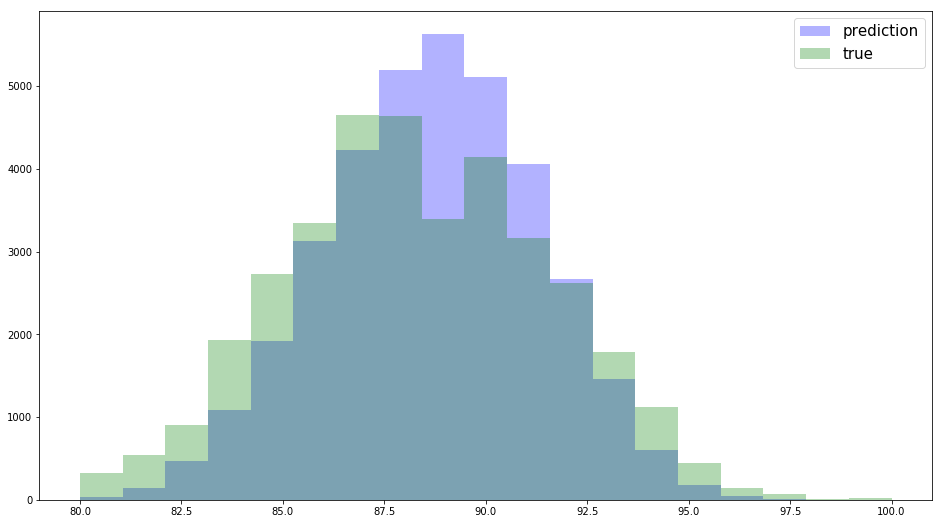

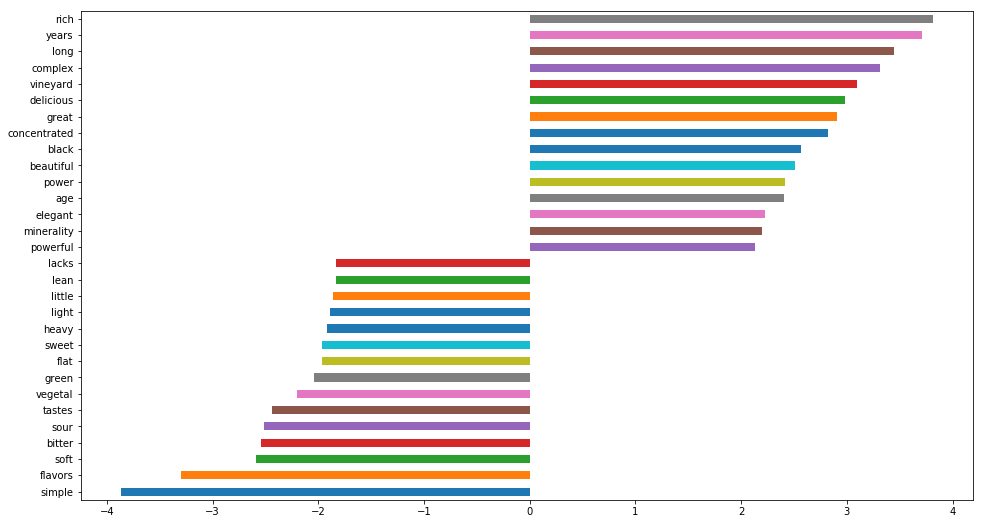

In [25]:
# Plot histogram of predicted score
fig = plt.figure()
ax = plt.gca()
ax.hist(to_point(y_pred2), bins=bins, alpha=0.3, color='b', label='prediction')
ax.hist(to_point(y_test),  bins=bins, alpha=0.3, color='g', label='true')
ax.legend(prop={'size':15})

# Plot the most important coefficients
coef = pd.Series(model2.coef_, index = indices_word)
num_coef = 15
imp_coef = pd.concat([coef.sort_values().head(num_coef),
                      coef.sort_values().tail(num_coef)])

plt.figure()
imp_coef.plot(kind='barh')